In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import optuna
import  os
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from utils import Optuna_for_LGB
from preprocess import convert_notation, region_encoding, region_grouping
PATH = '../data/'
TRAIN = True

In [2]:
train_df = pd.read_csv(PATH + 'train.csv')
test_df = pd.read_csv(PATH + 'test.csv')
train_df = convert_notation(train_df)
test_df = convert_notation(test_df)
train_df, test_df, le = region_encoding(train_df, test_df)
columns = list(test_df.columns)
columns.remove('index')
columns.remove('region')
train_df, test_df = region_grouping(train_df, test_df, columns, diff=True)
print(train_df.shape, test_df.shape)
train_df.head()

(4043, 68) (4046, 67)


,index,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,...,speechiness_region_mean_diff,speechiness_region_mean_diff_region_std_diff,instrumentalness_region_mean_diff,instrumentalness_region_mean_diff_region_std_diff,tempo_region_mean_diff,tempo_region_mean_diff_region_std_diff,tempo_min_region_mean_diff,tempo_min_region_mean_diff_region_std_diff,tempo_max_region_mean_diff,tempo_max_region_mean_diff_region_std_diff
0,0,10,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,...,0.190938,0.107738,0.654704,0.482039,6.425974,0.675942,11.464935,-15.919090,17.890909,-12.355278
1,1,8,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,...,-0.044342,-0.132965,-0.075721,-0.204536,-1.192626,-6.927914,42.826446,13.881056,41.633821,10.617623
2,2,3,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,...,0.168879,0.083626,-0.032721,-0.162285,-12.235772,-17.632036,-44.730229,-72.101236,-56.966001,-86.405871
3,3,10,45,301092,0.165667,0.245533,0.356578,-5.088788,0.868704,0.377025,...,0.033477,-0.043255,-0.040311,-0.177523,-9.450292,-14.893220,59.953216,29.820605,50.502924,19.607203
4,4,3,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,...,0.017855,-0.068502,0.013319,-0.137564,-1.619253,-7.055886,-13.886494,-41.858372,-15.505747,-45.344787


In [3]:
train_df.columns

Index(['index', 'genre', 'popularity', 'duration_ms', 'acousticness',
       'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
       'speechiness', 'instrumentalness', 'tempo', 'region', 'tempo_min',
       'tempo_max', 'popularity_mean', 'popularity_std', 'duration_ms_mean',
       'duration_ms_std', 'acousticness_mean', 'acousticness_std',
       'positiveness_mean', 'positiveness_std', 'danceability_mean',
       'danceability_std', 'loudness_mean', 'loudness_std', 'energy_mean',
       'energy_std', 'liveness_mean', 'liveness_std', 'speechiness_mean',
       'speechiness_std', 'instrumentalness_mean', 'instrumentalness_std',
       'tempo_mean', 'tempo_std', 'tempo_min_mean', 'tempo_min_std',
       'tempo_max_mean', 'tempo_max_std', 'popularity_region_mean_diff',
       'popularity_region_mean_diff_region_std_diff',
       'duration_ms_region_mean_diff',
       'duration_ms_region_mean_diff_region_std_diff',
       'acousticness_region_mean_diff',
       'acoustic

In [4]:
objective_args = {
    'num_leaves': {
        'type': 'int',
        'suggest_args': {
            'name': 'num_leaves',
            'low': 2,
            'high': 128,
        }
    },
    'max_depth': {
        'type': 'int',
        'suggest_args': {
            'name': 'max_depth',
            'low': 3,
            'high': 8,
        }
    },
    'min_data_in_leaf': {
        'type': 'int',
        'suggest_args': {
            'name': 'min_data_in_leaf',
            'low': 5,
            'high': 90,
        }
    },
    'n_estimators': {
        'type': 'int',
        'suggest_args': {
            'name': 'n_estimators',
            'low': 100,
            'high': 1000,
        }
    },
    'learning_rate': {
        'type': 'uniform',
        'suggest_args': {
            'name': 'learning_rate',
            'low': 0.0001,
            'high': 0.1
        }
    },
    'bagging_fraction': {
        'type': 'uniform',
        'suggest_args': {
            'name': 'bagging_fraction',
            'low': 0.0001,
            'high': 1.0,
        }
    },
    'feature_fraction': {
        'type': 'uniform',
        'suggest_args': {
            'name': 'feature_fraction',
            'low': 0.0001,
            'high': 1.0,
        }
    },
    'random_state': {
        'type': 'default',
        'value': 0
    },
    'objective': {
        'type': 'default',
        'value': 'cross_entropy'
    },
    'num_class': {
        'type': 'default',
        'value': 11
    },
    # 'class_weight': {
    #     'type': 'default',
    #     'value': class_weight
    # }
    
}
def evaluate_macroF1_lgb(true, pred):  
    # this follows the discussion in https://github.com/Microsoft/LightGBM/issues/1483
    pred = pred.reshape(len(np.unique(true)), -1).argmax(axis=0)
    f1 = f1_score(true, pred, average='macro')
    return ('macroF1', f1, True) 

pipeline_args = {
    'fit_attr': 'fit',
    'pred_attr': 'predict',
    'fit_args': {
        # 'X': x_train,
        # 'y': y_train,
        # 'eval_set': (x_test, y_test),
        'eval_metric': evaluate_macroF1_lgb,
        'eval_names': ['validation'],
        'early_stopping_rounds': 50,
        'verbose': -1,
        # 'feature_name': columns
        'categorical_feature': ['region']
    },
    # 'pred_args': {'X': x_test},
    'metric': lambda true, pred: f1_score(true, pred, average='macro'),
    # 'metric_args': {'true': y_test},
    'model': lgb.LGBMClassifier,
}

In [5]:
columns = list(test_df.columns)
columns.remove('index')
cv_num = 10
kf = StratifiedKFold(n_splits=cv_num, shuffle=True, random_state=0)
name = 'lgb_group'
x, y = train_df[columns], train_df.genre
ofl = Optuna_for_LGB()
optuna.logging.disable_default_handler()
score = list()
for cv, (train_valid_idx, test_idx) in enumerate(kf.split(np.zeros(train_df.shape[0]), y)):
    if cv <= 5:
        continue
    x_tv, x_test = x.iloc[train_valid_idx], x.iloc[test_idx]
    y_tv, y_test = y.iloc[train_valid_idx], y.iloc[test_idx]
    cv_score = list()
    for valid_cv, (train_idx, valid_idx) in enumerate(kf.split(np.zeros(x_tv.shape[0]), y_tv)):
        x_train, x_valid = x_tv.iloc[train_idx], x_tv.iloc[valid_idx]
        y_train, y_valid = y_tv.iloc[train_idx], y_tv.iloc[valid_idx]
        x_train = x_train.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)
        # x_train = region_fix(x_train, y_train, thre_count, le.transform(['unknown'])[0])
        pipeline_args['fit_args']['X'] = x_train
        pipeline_args['fit_args']['y'] = y_train
        pipeline_args['fit_args']['eval_set'] = (x_valid, y_valid)
        pipeline_args['fit_args']['feature_name'] = columns
        pipeline_args['pred_args'] = {'X': x_valid}
        pipeline_args['metric_args'] = {'true': y_valid}
        if TRAIN:
            params = ofl.parameter_tuning(pipeline_args, objective_args, 1000, -1, 0)

            best_iteration = params.pop('best_iteration_')
            model = lgb.LGBMClassifier(**params)
            model.fit(**pipeline_args['fit_args'])
            y_pred = model.predict_proba(x_test, model.best_iteration_)
            model.booster_.save_model('../model/{0}_{1}_{2}.txt'.format(name, cv, valid_cv))
        else:
            model = lgb.Booster(model_file='../model/{0}_{1}_{2}.txt'.format(name, cv, valid_cv))
            y_pred = model.predict(x_test).astype(np.float64)

        cv_score.append(f1_score(y_test, np.argmax(y_pred, axis=1), average='macro'))
    score.append(cv_score)

ng until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[125]	validation's multi_logloss: 0.900737	validation's macroF1: 0.648188
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[187]	validation's multi_logloss: 0.880967	validation's macroF1: 0.647203
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[162]	validation's multi_logloss: 0.894027	validation's macroF1: 0.654325
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[219]	validation's multi_logloss: 0.90904	validation's macroF1: 0.649949
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[239]	validation's multi_logloss: 0.942351	validation's macroF1: 0.626247
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[147]	validation's multi_logloss: 0.934663	validation's macro

In [6]:
score, np.mean(score, axis=1), np.mean(score)

([[0.5902938095220058,
   0.45529333249896614,
   0.5100288374587856,
   0.5037402021259015,
   0.5506471762512652,
   0.5153526509853638,
   0.4699787336070628,
   0.4890624004667756,
   0.5171116207085972,
   0.5282922623781606],
  [0.5684686669900216,
   0.5145984314370303,
   0.5106398191825999,
   0.5696929755937685,
   0.5158189630457843,
   0.5552658380075003,
   0.5317796719171406,
   0.5714927181489052,
   0.5912739072108569,
   0.5423666203996015],
  [0.49909003930123536,
   0.505978750915096,
   0.523172503031658,
   0.5198383471275733,
   0.49765957076640394,
   0.5314841838984161,
   0.5292033228610339,
   0.5624964902421431,
   0.5357368253282841,
   0.5299577644383628],
  [0.5018753653925706,
   0.564852204566455,
   0.5616459520871286,
   0.5161911967608392,
   0.519204233475054,
   0.5411480930066099,
   0.507118918884805,
   0.5428205554581995,
   0.5203085495722288,
   0.552419409221917],
  [0.5068797079301605,
   0.6070435113863105,
   0.5529636747028053,
   0.43380

In [7]:
sub_df = pd.read_csv(PATH + 'sample_submit.csv', header=None, names=['ID', 'Pred'])
prediction = np.zeros((test_df.shape[0], 11), dtype=np.float64)
x = test_df[columns]
for i in range(cv_num):
    for j in range(cv_num):
        model = lgb.Booster(model_file='../model/{0}_{1}_{2}.txt'.format(name, i, j))
        pred = model.predict(x).astype(np.float64)
        prediction += pred
prediction /= 100.0
sub_df.Pred = np.argmax(prediction, axis=1)
sub_df.head()

,ID,Pred
0,4046,8
1,4047,10
2,4048,8
3,4049,10
4,4050,8


<AxesSubplot:>

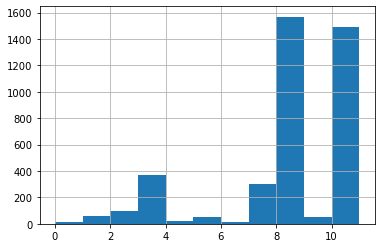

In [8]:
sub_df.Pred.hist(range=(0,11), bins=11)

In [9]:
sub_df.to_csv('../pred/{0}.csv'.format(name), index=None, header=None)